In [1]:
import numpy as np
import json
from utils import (
    load_itk, world_to_pixel, any_match,
    calc_iou, vanilla_nms_pytorch
)
from tqdm import tqdm
import pandas as pd
import torch
from monai.data.box_utils import non_max_suppression
from statistics import mean 

In [2]:
data_list_file_path = '/data/output/validation/test_parsed.json'
f = open(data_list_file_path)
data = json.load(f)

print(data['test'][0].keys())

dict_keys(['true_box', 'pred_box', 'score', 'image'])


In [3]:
metrics = []

for content in tqdm(data['test'][0:10]):

    img, origin, spacing = load_itk(content['image'])
    origin = np.array(list(reversed(origin)))
    spacing = np.array(list(reversed(spacing)))

    targets = []
    boxes = []
    scores = []

    y_coords = []
    x_coords = []
    
    for true_box in content['true_box']:
        world_coord_cent = np.array((true_box[0], true_box[1], true_box[2]))
        world_coord_diam = np.array((true_box[3], true_box[4], true_box[5]))

        voxel_min, voxel_max = world_to_pixel(
            origin, spacing, world_coord_cent, world_coord_diam
        )

        targets.append({
            "voxel_min": voxel_min.astype(int),
            "voxel_max": voxel_max.astype(int)
        })

    for pred_box, score in zip(content['pred_box'], content['score']):

        world_coord_cent = np.array((pred_box[0], pred_box[1], pred_box[2]))
        world_coord_diam = np.array((pred_box[3], pred_box[4], pred_box[5]))

        voxel_min, voxel_max = world_to_pixel(
            origin, spacing, world_coord_cent, world_coord_diam
        )

        boxes.append([
            voxel_min[0].astype(int), 
            voxel_min[1].astype(int), 
            voxel_min[2].astype(int),
            voxel_max[0].astype(int), 
            voxel_max[1].astype(int), 
            voxel_max[2].astype(int)
        ])

        scores.append(score)

    boxes = torch.Tensor(boxes)
    scores = torch.Tensor(scores)

    ### NMS usage
    keep = non_max_suppression(boxes, scores, 0.1)
    filtered_boxes = boxes[keep]

    ### without NMS
    # filtered_boxes = []
    # for box in boxes:
    #     filtered_boxes.append(box)

    iou = []
    for target in targets:
        for index in range(0, len(targets)):
            converted = {
                'voxel_min': np.array(
                    (filtered_boxes[index][0],
                    filtered_boxes[index][1],
                    filtered_boxes[index][2])
                ).astype(int),
                'voxel_max': np.array(
                    (filtered_boxes[index][3],
                    filtered_boxes[index][4],
                    filtered_boxes[index][5])
                ).astype(int)
            }
            if any_match(converted, target):
                iou.append(calc_iou(target, converted))
    
    metrics.append({
        "image": content['image'],
        "IoU": 0 if len(iou) == 0 else iou[0] if len(iou) == 1 else mean(iou)
    })

100%|██████████| 10/10 [00:24<00:00,  2.41s/it]


In [4]:
metrics = pd.DataFrame.from_dict(metrics)
metrics.head()

,image,IoU
0,/data/LUNA16_Images_resample/1.3.6.1.4.1.14519...,0.000000
1,/data/LUNA16_Images_resample/1.3.6.1.4.1.14519...,1.000000
2,/data/LUNA16_Images_resample/1.3.6.1.4.1.14519...,0.909091
3,/data/HC_Images_resample/PL155113087338785/PL1...,0.779412
4,/data/LUNA16_Images_resample/1.3.6.1.4.1.14519...,0.837258


In [12]:
metrics.to_csv('results.csv', index=False)

,image,IoU
0,/data/LUNA16_Images_resample/1.3.6.1.4.1.14519...,0.000000
1,/data/LUNA16_Images_resample/1.3.6.1.4.1.14519...,1.000000
2,/data/LUNA16_Images_resample/1.3.6.1.4.1.14519...,0.909091
3,/data/HC_Images_resample/PL155113087338785/PL1...,0.779412
4,/data/LUNA16_Images_resample/1.3.6.1.4.1.14519...,0.837258


count    155.000000
mean       0.503983
std        0.362429
min        0.000000
25%        0.000000
50%        0.671031
75%        0.792990
max        1.000000
Name: IoU, dtype: float64

array([[<Axes: title={'center': 'IoU'}>]], dtype=object)

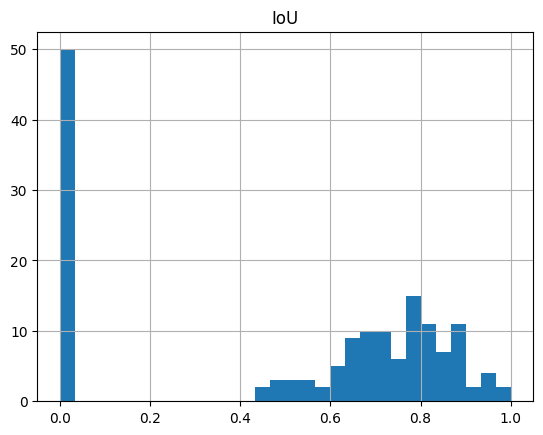